In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [3]:
from PIL import Image
import PIL
import numpy as np
from tensorflow.keras.utils import Sequence
from glob import glob
from tqdm import tqdm
import pandas as pd 
import imgaug.augmenters as iaa

In [4]:
dataset_name = 'face_dataset'
train_test_dataset_split = "face_dataset/train_test_images.csv"
model_path = 'face_dataset_0_1/semantic'

original_dataset_name = 'face_dataset'

In [5]:
def get_images_from_path(path):
    images_list_jpeg = glob(path+"*.jpeg", recursive = True)
    images_list_jpg = glob(path+"*.jpg", recursive = True)
    images_list_png = glob(path+"*.png", recursive = True)
    return images_list_jpeg + images_list_jpg + images_list_png

In [6]:
path = dataset_name+"/images/"
original_dataset_path = original_dataset_name+"/images/"
dataset = get_images_from_path(path)
original_dataset = get_images_from_path(original_dataset_path)
print(len(dataset))
print(len(original_dataset))

30000
30000


In [7]:
class Mygenerator(Sequence):
    def __init__(self, data, batch_size, readers, training = False):
        self.data = data
        self.batch_size = batch_size
        self.readers = readers
        self.training = training
    def __len__(self):
        return int(np.ceil(len(self.data)/float(self.batch_size)))
    
    def __getitem__(self,idx):
        batch = self.data[ idx * self.batch_size: (idx + 1) * self.batch_size]

        x = []
        y = []

        for filename in batch:
            x_, y_ = self.readers(filename,self.training)
            x.append(x_)
            y.append(y_)
        return np.array(x), np.array(y)

In [8]:
def padding_image(img, padd, resize = False, resample = PIL.Image.BICUBIC, **kwagrs ):
    if isinstance(padd, int):
        top = padd
        button = padd
        left = padd
        right = padd
    else:
        top, button, left, right = padd
    img_arr = np.array(img)
    if len(img_arr.shape) == 3:
        img_result =  Image.fromarray(np.uint8(np.pad(img_arr, [(top,button),(left,right),(0,0)], **kwagrs)))
    elif len(img_arr.shape) == 2 or img_arr.shape[2] == 1:
        img_result =  Image.fromarray(np.uint8(np.pad(img_arr, [(top,button),(left,right)], **kwagrs)))
        
    if resize:
        return img_result.resize(img.size, resample = resample)
    return img_result

In [9]:
def read_x_y(filename, training = False, debug = False):
    input_ = Image.open(filename).convert("RGB").resize((256,256))
    output_ = Image.open(filename.replace("images","gif").replace(".jpg",".gif")).resize((256,256), resample = PIL.Image.NEAREST).convert("L")

    if training:
        if np.random.random()  > 0.5:
            input_ = input_.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            output_ = output_.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        
        #random_padding = np.random.randint(0, int(256 / 4))
        
        rand = np.random.randint
        random_padding = rand(0, int(256 / 4)), rand(0, int(256 / 4)), rand(0, int(256 / 4)), rand(0, int(256 / 4))
        input_ = padding_image(input_, padd = random_padding,mode = 'edge', resize=True)
        output_ = padding_image(output_, padd = random_padding, resize=True,mode = 'constant', constant_values = 0, resample = PIL.Image.NEAREST)

        
        random_k = np.random.randint(5,20)
        
        deg_random = np.random.randint(-30,30)
        input_ = input_.rotate(deg_random)
        output_ = output_.rotate(deg_random)
        
        seq = iaa.Sometimes(0.8, iaa.Sequential([
            #iaa.Pad(percent= (0.0, 1.0), pad_mode = 'constant'),
            iaa.MultiplyBrightness((0.5, 1.5)),
            iaa.MultiplyHue((0.5, 1.5)),
            iaa.GaussianBlur(sigma=(0, 1.5)),
            iaa.Sometimes(0.2, iaa.MotionBlur(k=random_k, angle=[-45, 45]), iaa.GaussianBlur(sigma=(0, 1.5))),
        ]))
        input_ = seq(images = np.array(input_)[np.newaxis])[0]
        
    if debug:
        print(random_k)
        print(random_padding)
        print(np.unique(output_))
    c = np.array(output_)[...,np.newaxis] / 255
    return (np.array(input_) * 1 / 127.5) - 1, np.concatenate([c,1 - c],axis=-1)

In [10]:
len(dataset)

30000

In [11]:
r = read_x_y(dataset[0], True, True)

19
(19, 39, 41, 43)
[  0 255]


In [12]:
np.unique(np.uint8(r[1]))

array([0, 1], dtype=uint8)

In [13]:
r[1].shape

(256, 256, 2)

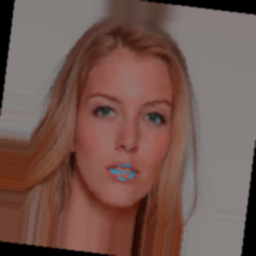

In [14]:
Image.fromarray(np.uint8((r[0] + 1) * 127.5))

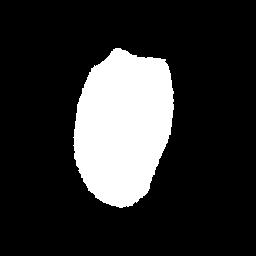

In [15]:
Image.fromarray(np.uint8((r[1]) * 255))

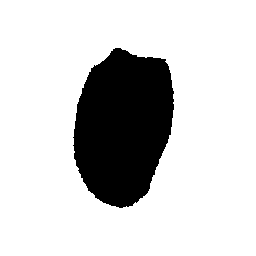

In [16]:
Image.fromarray(np.uint8(r[1][:,:,1])* 255)

In [17]:
np.unique(r[1][...,1])

array([0., 1.])

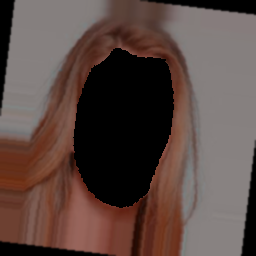

In [18]:
Image.fromarray(np.uint8(((r[0] + 1) * np.repeat(r[1][...,1][:, :, np.newaxis], 3, axis=2)) * 127.5))

In [19]:
dataset

['face_dataset/images/20229.jpg',
 'face_dataset/images/16931.jpg',
 'face_dataset/images/24836.jpg',
 'face_dataset/images/27888.jpg',
 'face_dataset/images/3651.jpg',
 'face_dataset/images/14221.jpg',
 'face_dataset/images/22530.jpg',
 'face_dataset/images/10478.jpg',
 'face_dataset/images/10995.jpg',
 'face_dataset/images/970.jpg',
 'face_dataset/images/7073.jpg',
 'face_dataset/images/23980.jpg',
 'face_dataset/images/27368.jpg',
 'face_dataset/images/11757.jpg',
 'face_dataset/images/28251.jpg',
 'face_dataset/images/11167.jpg',
 'face_dataset/images/19979.jpg',
 'face_dataset/images/4387.jpg',
 'face_dataset/images/18061.jpg',
 'face_dataset/images/1708.jpg',
 'face_dataset/images/2247.jpg',
 'face_dataset/images/11051.jpg',
 'face_dataset/images/10358.jpg',
 'face_dataset/images/1457.jpg',
 'face_dataset/images/14253.jpg',
 'face_dataset/images/1719.jpg',
 'face_dataset/images/21758.jpg',
 'face_dataset/images/17908.jpg',
 'face_dataset/images/24024.jpg',
 'face_dataset/images/4

In [20]:
import pandas as pd 
df_train_test = pd.read_csv(train_test_dataset_split)

In [21]:
df_images_original = pd.DataFrame(original_dataset,columns = ["image_path"])


In [23]:
test = df_train_test[df_train_test.test].image_path.to_list()
test

['face_dataset/images/29332.jpg',
 'face_dataset/images/2910.jpg',
 'face_dataset/images/14749.jpg',
 'face_dataset/images/8308.jpg',
 'face_dataset/images/3607.jpg',
 'face_dataset/images/17967.jpg',
 'face_dataset/images/29368.jpg',
 'face_dataset/images/26956.jpg',
 'face_dataset/images/23708.jpg',
 'face_dataset/images/27054.jpg',
 'face_dataset/images/8581.jpg',
 'face_dataset/images/22217.jpg',
 'face_dataset/images/25796.jpg',
 'face_dataset/images/22325.jpg',
 'face_dataset/images/16263.jpg',
 'face_dataset/images/26672.jpg',
 'face_dataset/images/3193.jpg',
 'face_dataset/images/24680.jpg',
 'face_dataset/images/10240.jpg',
 'face_dataset/images/14863.jpg',
 'face_dataset/images/22197.jpg',
 'face_dataset/images/8390.jpg',
 'face_dataset/images/3544.jpg',
 'face_dataset/images/28123.jpg',
 'face_dataset/images/19722.jpg',
 'face_dataset/images/18049.jpg',
 'face_dataset/images/15251.jpg',
 'face_dataset/images/3616.jpg',
 'face_dataset/images/17743.jpg',
 'face_dataset/images/

In [24]:
train = df_train_test[df_train_test.train].image_path.to_list()
train

['face_dataset/images/20712.jpg',
 'face_dataset/images/3247.jpg',
 'face_dataset/images/7615.jpg',
 'face_dataset/images/15950.jpg',
 'face_dataset/images/8391.jpg',
 'face_dataset/images/4094.jpg',
 'face_dataset/images/13767.jpg',
 'face_dataset/images/9692.jpg',
 'face_dataset/images/3123.jpg',
 'face_dataset/images/23168.jpg',
 'face_dataset/images/29551.jpg',
 'face_dataset/images/21269.jpg',
 'face_dataset/images/25582.jpg',
 'face_dataset/images/9322.jpg',
 'face_dataset/images/29334.jpg',
 'face_dataset/images/21081.jpg',
 'face_dataset/images/25747.jpg',
 'face_dataset/images/5129.jpg',
 'face_dataset/images/29651.jpg',
 'face_dataset/images/11732.jpg',
 'face_dataset/images/25770.jpg',
 'face_dataset/images/14737.jpg',
 'face_dataset/images/17412.jpg',
 'face_dataset/images/26029.jpg',
 'face_dataset/images/9798.jpg',
 'face_dataset/images/26054.jpg',
 'face_dataset/images/25441.jpg',
 'face_dataset/images/5375.jpg',
 'face_dataset/images/29722.jpg',
 'face_dataset/images/10

In [25]:
df_train_test

,image_path,train,test
0,face_dataset/images/20712.jpg,True,False
1,face_dataset/images/3247.jpg,True,False
2,face_dataset/images/7615.jpg,True,False
3,face_dataset/images/15950.jpg,True,False
4,face_dataset/images/8391.jpg,True,False
...,...,...,...
29995,face_dataset/images/27331.jpg,False,True
29996,face_dataset/images/9575.jpg,False,True
29997,face_dataset/images/20759.jpg,False,True
29998,face_dataset/images/24752.jpg,False,True


In [26]:
len(dataset)

30000

In [27]:
print(len(train))
print(len(test))

24000
6000


In [28]:
set(train).intersection(set(test))

set()

In [29]:
batch_size= 20
training_generator = Mygenerator(train,batch_size,read_x_y,training = True)
test_generator = Mygenerator(test,batch_size,read_x_y, training=False)

In [30]:
def GeneralisedDice(y_true, y_pred, *args, **kwargs):
    tc = y_true 
    pc = y_pred
    # w: Tensor = 1 / ((einsum("bcwh->bc", tc).type(torch.float32) + 1e-10) ** 2)
    w = 1 / ((tf.einsum('bwhc->bc',tc) + 1e-10) ** 2)
    # intersection: Tensor = w * einsum("bcwh,bcwh->bc", pc, tc)
    intersection = w * tf.einsum('bwhc,bwhc->bc',pc,tc) 
    #intersection = w * (tf.keras.backend.sum(pc * tc,axis=(1,2),keepdims=True))
    # union: Tensor = w * (einsum("bcwh->bc", pc) + einsum("bcwh->bc", tc))
    union = w * (tf.einsum('bwhc->bc',pc) + tf.einsum('bwhc->bc',tc))
    # divided: Tensor = 1 - 2 * (einsum("bc->b", intersection) + 1e-10) / (einsum("bc->b", union) + 1e-10)
    divided = 1 - 2 * (tf.einsum('bc->b',intersection)+ 1e-10) / (tf.einsum('bc->b',union) + 1e-10)
    return tf.reduce_mean(divided)

In [31]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import tensorflow as tf

def unet():
    inputs = Input((256,256,3))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(2, 1, activation = 'relu')(conv9)
    #conv10 = Reshape((-1, 2))(conv10)
    conv10 = Softmax(axis=-1)(conv10)
    return Model(inputs = inputs, outputs = conv10)

In [ ]:
model = unet()
model.compile(optimizer =  Adam(1e-5), loss= GeneralisedDice , metrics = ['accuracy'])#"categorical_crossentropy"

In [33]:
#model = tf.keras.models.load_model('semantic_model_small_2_4/semantic', custom_objects = {"GeneralisedDice":GeneralisedDice})

In [34]:
model.fit(training_generator, validation_data= test_generator, epochs= 5)

Epoch 1/5


2024-08-25 21:21:58.663742: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-25 21:21:59.083122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-08-25 21:22:01.569256: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-25 21:22:01.911802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-25 21:22:01.949182: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7191e38ca2f0 initialized for platform CUDA 

1200/1200 [==============================] - 1060s 854ms/step - loss: 0.1292 - accuracy: 0.9362 - val_loss: 0.0601 - val_accuracy: 0.9554
Epoch 2/5
1200/1200 [==============================] - 1026s 855ms/step - loss: 0.0683 - accuracy: 0.9675 - val_loss: 0.0448 - val_accuracy: 0.9666
Epoch 3/5
1200/1200 [==============================] - 1026s 855ms/step - loss: 0.0564 - accuracy: 0.9731 - val_loss: 0.0410 - val_accuracy: 0.9694
Epoch 4/5
1200/1200 [==============================] - 1027s 855ms/step - loss: 0.0504 - accuracy: 0.9760 - val_loss: 0.0391 - val_accuracy: 0.9707
Epoch 5/5
1200/1200 [==============================] - 1026s 855ms/step - loss: 0.0474 - accuracy: 0.9774 - val_loss: 0.0374 - val_accuracy: 0.9720


1/1 [==============================] - 0s 422ms/step


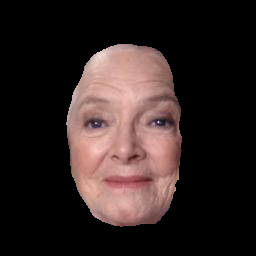

1/1 [==============================] - 0s 11ms/step


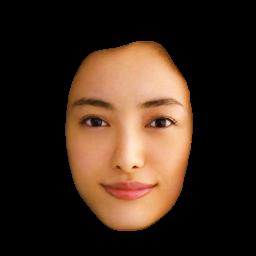

1/1 [==============================] - 0s 11ms/step


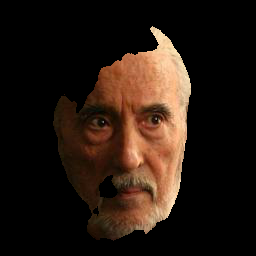

1/1 [==============================] - 0s 12ms/step


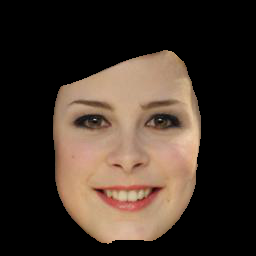

1/1 [==============================] - 0s 11ms/step


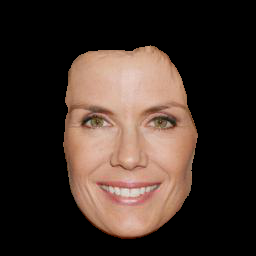

1/1 [==============================] - 0s 12ms/step


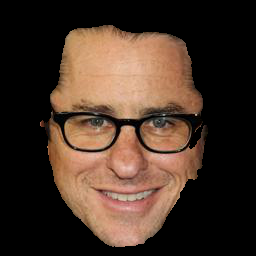

1/1 [==============================] - 0s 11ms/step


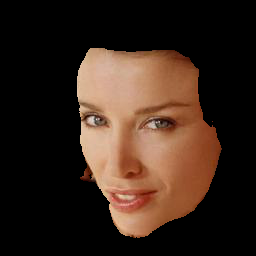

1/1 [==============================] - 0s 11ms/step


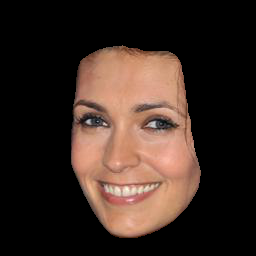

1/1 [==============================] - 0s 12ms/step


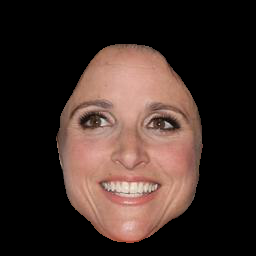

1/1 [==============================] - 0s 11ms/step


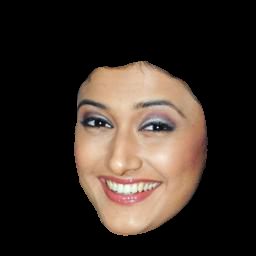

In [35]:
for i in range(10):
    img_test = Image.open(test[i])
    prediction = model.predict( np.array(img_test)[np.newaxis,:,:,:] )
    display(Image.fromarray(np.uint8((prediction[0,:,:,0:1]).astype(np.int64) * img_test)))

In [36]:
model.save(model_path)


INFO:tensorflow:Assets written to: face_dataset_0_1/semantic/assets


INFO:tensorflow:Assets written to: face_dataset_0_1/semantic/assets


In [ ]:
y_pred = model.predict(test_generator)

In [ ]:
data = [batch for batch in test_generator]

In [ ]:
model.save(model_path)


In [ ]:
def get_pred_true(model, test, test_generator):
    data = [batch for batch in test_generator]
    
    input_list = []
    label_list = []
    image_name_list = []
    for i in range(len(data)):
        input_list.append(data[i][0])
        label_list.append(data[i][1])
        image_name_list.append(test[i*data[i][1].shape[0]:(i+1)*data[i][1].shape[0]])
    X = np.concatenate(input_list, axis = 0)
    y_true = np.concatenate(label_list, axis = 0)
    image_name_list = np.concatenate(image_name_list, axis = 0)
    y_pred = model.predict(test_generator)
    return X, y_true, y_pred, image_name_list


def pill_image(x):
    return Image.fromarray(np.uint8(x))


def unstandarize(x):
    return (x + 1) * 127.5

In [ ]:
X_list, y_true_list, y_pred_list, image_name_list = get_pred_true(model, test, test_generator)

In [ ]:
for i,values in enumerate(zip(X_list, y_true_list, y_pred_list, image_name_list)):
    x, y_true, y_pred, image_name = values
    print("------------")
    print(image_name)
    display(pill_image(unstandarize(x)))
    display(pill_image((y_true * 255)[:,:,0]))
    display(pill_image((y_pred * 255)[:,:,0]))
    display(pill_image((y_pred * 255)[:,:,1]))
    display(pill_image((y_true * 255)[:,:,1]))
